## Checking if using GPU

In [1]:
!nvidia-smi

Sun Dec 10 12:33:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8               9W / 320W |      1MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Necessary imports

In [2]:
from fastai.vision.all import *
from fastai.metrics import error_rate

## Dataset


If you are running this in your own machine, once you have done this step and the following one (pepare the data), you can skip them, as you'll have already the data ready.

If you are running this on colab (or similar platforms), as each time you are connected to a different runtime your hard disk is from a new machine, you'll have to do these steps. Unless you are using google drive to store the data, then, this data will be stored there, and you'll already have it always (although you have to connect to google drive each time).



**Another** thing that's included with fastai (besides tools for creating and training neural networks) is a collection of URLs of some of the most used datasets available (and they are stored on amazon's AWS, so we can easily download them into our machines).


In [3]:
dir(URLs)

['ADULT_SAMPLE',
 'AG_NEWS',
 'AMAZON_REVIEWS',
 'AMAZON_REVIEWS_POLARITY',
 'BIWI_HEAD_POSE',
 'BIWI_SAMPLE',
 'CALTECH_101',
 'CAMVID',
 'CAMVID_TINY',
 'CARS',
 'CIFAR',
 'CIFAR_100',
 'COCO_SAMPLE',
 'COCO_TINY',
 'CUB_200_2011',
 'DBPEDIA',
 'DOGS',
 'FLOWERS',
 'FOOD',
 'GOOGLE',
 'HUMAN_NUMBERS',
 'IMAGENETTE',
 'IMAGENETTE_160',
 'IMAGENETTE_320',
 'IMAGEWANG',
 'IMAGEWANG_160',
 'IMAGEWANG_320',
 'IMAGEWOOF',
 'IMAGEWOOF_160',
 'IMAGEWOOF_320',
 'IMDB',
 'IMDB_SAMPLE',
 'LOCAL_PATH',
 'LSUN_BEDROOMS',
 'MACAQUES',
 'MDL',
 'ML_100k',
 'ML_SAMPLE',
 'MNIST',
 'MNIST_SAMPLE',
 'MNIST_TINY',
 'MNIST_VAR_SIZE_TINY',
 'MT_ENG_FRA',
 'OPENAI_TRANSFORMER',
 'PASCAL_2007',
 'PASCAL_2012',
 'PETS',
 'PLANET_SAMPLE',
 'PLANET_TINY',
 'S3',
 'S3_AUDI',
 'S3_COCO',
 'S3_IMAGE',
 'S3_IMAGELOC',
 'S3_MODEL',
 'S3_NLP',
 'SIIM_SMALL',
 'SOGOU_NEWS',
 'TCGA_SMALL',
 'URL',
 'WIKITEXT',
 'WIKITEXT_TINY',
 'WT103_BWD',
 'WT103_FWD',
 'YAHOO_ANSWERS',
 'YELP_REVIEWS',
 'YELP_REVIEWS_POLARITY',
 

We'll use one of the provided datasets with FAST.AI. This one has dog and cat images. 


In [4]:
dataset = untar_data(URLs.DOGS)

In [5]:
dataset.ls()

(#4) [Path('/root/.fastai/data/dogscats/sample'),Path('/root/.fastai/data/dogscats/train'),Path('/root/.fastai/data/dogscats/valid'),Path('/root/.fastai/data/dogscats/test1')]

As you can see, we have some subdirectories on this dataset (each one is organized differently). In this case, we have a train, test, and validation directory

## Creating dataloaders

In [6]:
data_train = dataset/"train"
data_test1 = dataset/"test1"
data_valid = dataset/"valid"

We get all the filenames of the train part of the dataset (for a *real* example we should do this with train, valid, and test directories, sepparately

In [7]:
fnames = get_image_files(data_train, recurse=True)

We take a look at some filenames

In [8]:
fnames[-3:], fnames[:-3]

((#3) [Path('/root/.fastai/data/dogscats/train/dogs/dog.9467.jpg'),Path('/root/.fastai/data/dogscats/train/dogs/dog.11276.jpg'),Path('/root/.fastai/data/dogscats/train/dogs/dog.4555.jpg')],
 (#22997) [Path('/root/.fastai/data/dogscats/train/cats/cat.2921.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.10435.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.394.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.4319.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.5202.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.4865.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.3570.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.2266.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.9021.jpg'),Path('/root/.fastai/data/dogscats/train/cats/cat.4785.jpg')...])

We cab see they are classified as cats and dogs, and filenames follow a pattern:

~~~ 
[cat|dog].<number>.jpg
~~~ 
    
(theres another possible pattern):

~~~ 
[cats|dogs]/<filename>.jpg
~~~ 


This will allow us to assign labels to the images based on the filename, and use a regular expression (regex) to do that (as fastai provides with a method to apply a regex to filenames to get labels). 

In [9]:
pattern = r'([cd][ao][gt])\.\d+\.jpg$'

We now create the dataloader from our dataset, resizing images to 460px first, and then to 224px for training (to fit more and better on the GPU).

In [10]:
data = ImageDataLoaders.from_name_re(
    data_train, fnames, pattern,item_tfms=Resize(460), batch_tfms=aug_transforms(size=224) )

## Neural Network

We create our neuralnetwork, starting with RESNET34.

In [11]:
learn = vision_learner(data, resnet34, metrics=error_rate)

We find the learning rate.

SuggestedLRs(valley=0.0006918309954926372)

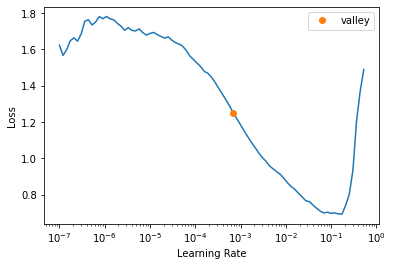

In [12]:
learn.lr_find()

We now can train the network (fit_one_cycle changes LR during training).  

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.099717,0.029652,0.010870,01:42
1,0.049478,0.026881,0.011522,01:42
2,0.039281,0.021203,0.009348,01:42
3,0.032053,0.019607,0.008696,01:42


We save the model, so we can use it for inference faster.

In [14]:
learn.save('round1')

Path('/root/.fastai/data/dogscats/train/models/round1.pth')

## Inference

We can create a new neural network, same characteristics as previous one

In [15]:
learn2 = vision_learner(data, resnet34, metrics=error_rate)

And load it with the saved weights to skip training.

In [16]:
learn2 = learn2.load('round1')

We have utility classes (ClassificationInterpretation) to run interpretation for classifiers.

In [17]:
interp = ClassificationInterpretation.from_learner(learn2)

We can compute the performance of our classifier.

In [18]:
losses, idxs = interp.top_losses()

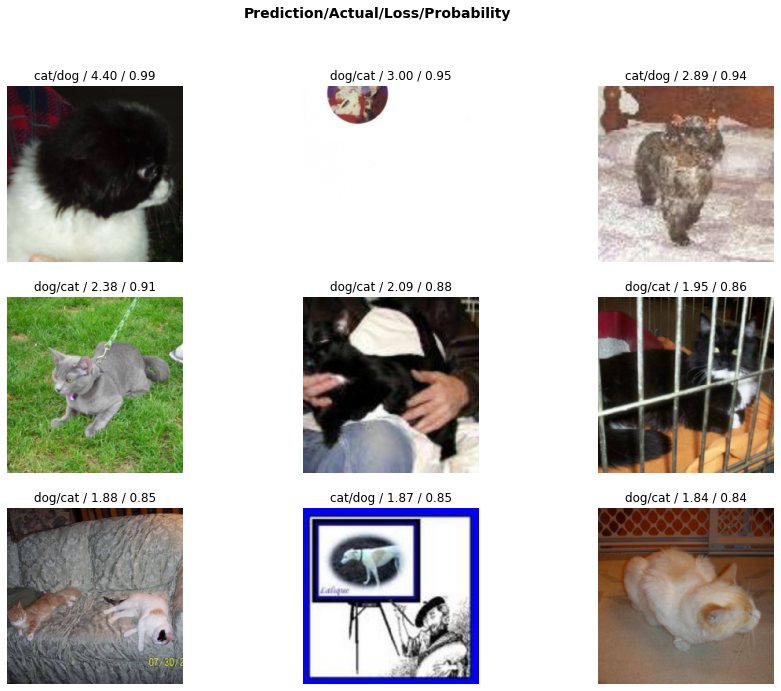

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

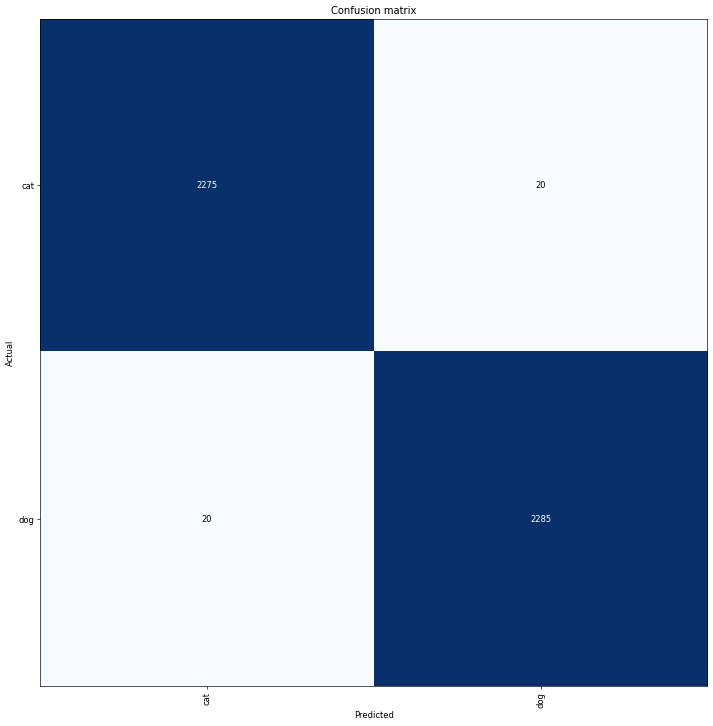

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)